In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed
import umap
import pandas as pd
from datetime import datetime


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=FutureWarning)


In [3]:
from avgn.utils.paths import DATA_DIR, most_recent_subdirectory, ensure_dir

In [4]:
DATASET_ID = 'batsong_isolate_segmented'

In [5]:
# create a unique datetime identifier for the files output by this notebook
DT_ID = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
DT_ID

'2020-03-01_19-59-47'

In [6]:
from avgn.utils.hparams import HParams
from avgn.dataset import DataSet

In [7]:
from avgn.signalprocessing.create_spectrogram_dataset import prepare_wav, create_label_df, get_row_audio

### create dataset

In [8]:
hparams = HParams(
    num_mel_bins = 32,
    mel_lower_edge_hertz=3000,
    mel_upper_edge_hertz=110000,
    butter_lowcut = 500,
    butter_highcut = 120000,
    ref_level_db = 20,
    min_level_db = -40,
    mask_spec = True,
    win_length_ms = 0.5,
    hop_length_ms = 0.05,
    mask_spec_kwargs = {"spec_thresh": 0.9, "offset": 1e-10},
    n_jobs = -1,
    verbosity=1,
    nex = -1
)

In [9]:
# create a dataset object
dataset = DataSet(DATASET_ID, hparams = hparams)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done 648 tasks      | elapsed:    5.0s


[Parallel(n_jobs=-1)]: Done 5617 out of 5617 | elapsed:    5.6s finished


/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3

In [10]:
dataset.sample_json

OrderedDict([('fid', 149126),
             ('Treatment ID', 17),
             ('Recording channel', 1),
             ('Recording time', '2012-12-20 03:25:12'),
             ('indvs',
              OrderedDict([('0',
                            OrderedDict([('syllables',
                                          OrderedDict([('start_times',
                                                        [4e-06]),
                                                       ('end_times',
                                                        [1.379648]),
                                                       ('addressee', [0]),
                                                       ('context',
                                                        ['Isolation']),
                                                       ('emit_prevoc_act',
                                                        [0]),
                                                       ('add_prevoc_act', [0]),
                       

#### Create dataset based upon JSON

In [11]:
from joblib import Parallel, delayed
n_jobs = -1; verbosity = 1

In [12]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(create_label_df)(
            dataset.data_files[key].data,
            hparams=dataset.hparams,
            labels_to_retain=[],
            unit="elements",
            dict_features_to_retain = [],
            key = key,
        )
        for key in tqdm(dataset.data_files.keys())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 182 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 1146 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done 2546 tasks      | elapsed:    5.2s
[Parallel(n_jobs=-1)]: Done 4346 tasks      | elapsed:    8.7s


[Parallel(n_jobs=-1)]: Done 5570 out of 5617 | elapsed:   10.8s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 5617 out of 5617 | elapsed:   10.8s finished


31646

In [13]:
syllable_df[:3]

start_time  end_time indv  indvi                 key
0      0.2140    0.3065    0      0  121220031934346505
1      0.3165    0.3360    0      0  121220031934346505
2      0.3375    0.3590    0      0  121220031934346505

### get audio for dataset

In [14]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllable_dfs = parallel(
        delayed(get_row_audio)(
            syllable_df[syllable_df.key == key], 
            dataset.data_files[key].data['wav_loc'], 
            dataset.hparams
        )
        for key in tqdm(syllable_df.key.unique())
    )
syllable_df = pd.concat(syllable_dfs)
len(syllable_df)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done  56 tasks      | elapsed:    0.8s
[Parallel(n_jobs=-1)]: Done 656 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done 1656 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 3056 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 4856 tasks      | elapsed:   29.8s


[Parallel(n_jobs=-1)]: Done 5476 out of 5476 | elapsed:   33.1s finished


31646

In [15]:
syllable_df[:3]

start_time  end_time indv  indvi                 key  \
0      0.2140    0.3065    0      0  121220031934346505   
1      0.3165    0.3360    0      0  121220031934346505   
2      0.3375    0.3590    0      0  121220031934346505   

                                               audio    rate  
0  [-0.0027430977, -0.0027036294, -0.0024923368, ...  250000  
1  [-0.002012212, -0.0023480833, -0.0030589635, -...  250000  
2  [0.0013279757, 0.00045214038, -0.0008202726, -...  250000

In [16]:
sylls = syllable_df.audio.values

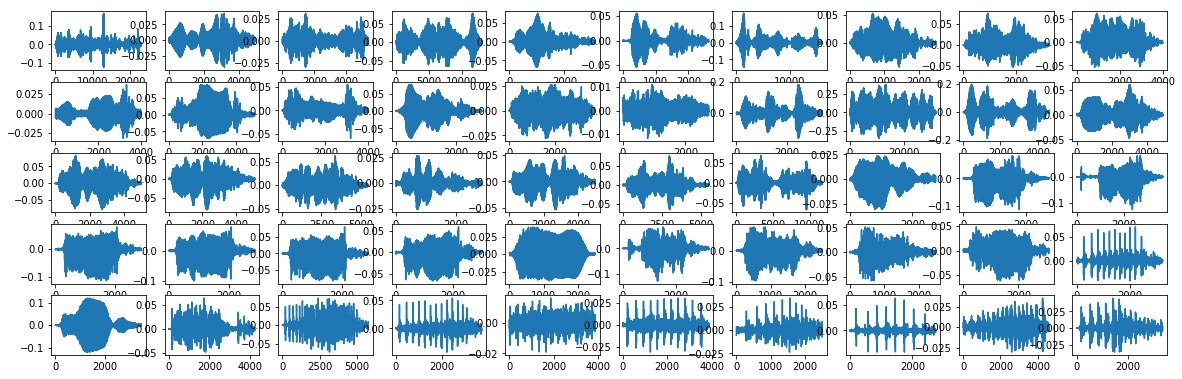

In [17]:
nrows = 5
ncols = 10
zoom = 2
fig, axs = plt.subplots(ncols=ncols, nrows = nrows,figsize = (ncols*zoom, nrows+zoom/1.5))
for i, syll in tqdm(enumerate(sylls), total = nrows*ncols):
    ax = axs.flatten()[i]
    ax.plot(syll)
    if i == nrows*ncols -1:
        break

In [18]:
syllable_df['audio'] = [i/np.max(i) for i in tqdm(syllable_df.audio.values)]

### Create spectrograms

In [19]:
from avgn.visualization.spectrogram import draw_spec_set
from avgn.signalprocessing.create_spectrogram_dataset import make_spec, mask_spec, log_resize_spec, pad_spectrogram

In [20]:
syllables_wav = syllable_df.audio.values
syllables_rate = syllable_df.rate.values

In [21]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    # create spectrograms
    syllables_spec = parallel(
        delayed(make_spec)(
            syllable,
            rate,
            hparams=dataset.hparams,
            mel_matrix=dataset.mel_matrix,
            use_mel=True,
            use_tensorflow=False,
        )
        for syllable, rate in tqdm(
            zip(syllables_wav, syllables_rate),
            total=len(syllables_rate),
            desc="getting syllable spectrograms",
            leave=False,
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1034 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 4534 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 9434 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done 15734 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 23434 tasks      | elapsed:   26.6s


[Parallel(n_jobs=-1)]: Done 31646 out of 31646 | elapsed:   35.6s finished


### Rescale spectrogram
- using log rescaling

In [22]:
log_scaling_factor = 4

In [23]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:
    syllables_spec = parallel(
        delayed(log_resize_spec)(spec, scaling_factor=log_scaling_factor)
        for spec in tqdm(syllables_spec, desc="scaling spectrograms", leave=False)
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.0s
[Parallel(n_jobs=-1)]: Done 6912 tasks      | elapsed:    2.0s


[Parallel(n_jobs=-1)]: Done 31646 out of 31646 | elapsed:    8.4s finished


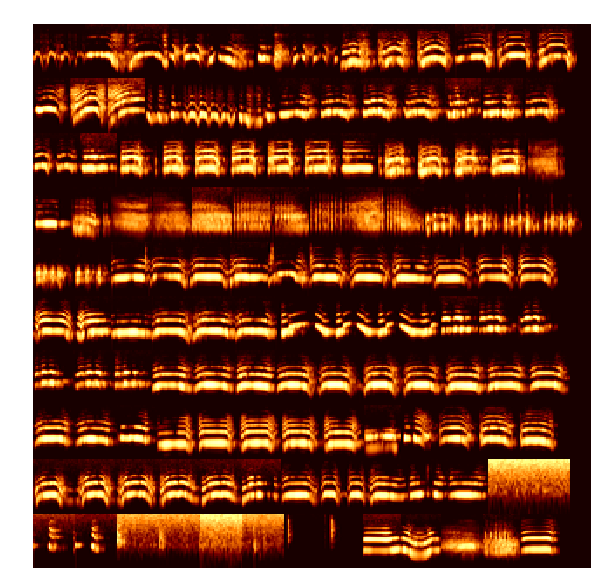

In [24]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=10)

### Pad spectrograms

In [25]:
syll_lens = [np.shape(i)[1] for i in syllables_spec]
pad_length = np.max(syll_lens)

In [26]:
syllable_df[:3]

start_time  end_time indv  indvi                 key  \
0      0.2140    0.3065    0      0  121220031934346505   
1      0.3165    0.3360    0      0  121220031934346505   
2      0.3375    0.3590    0      0  121220031934346505   

                                               audio    rate  
0  [-0.01634356, -0.016108407, -0.01484951, -0.01...  250000  
1  [-0.04675521, -0.054559425, -0.07107724, -0.05...  250000  
2  [0.04236861, 0.014425384, -0.026170516, -0.043...  250000

In [27]:
import seaborn as sns

/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/mnt/cube/tsainbur/conda_envs/tpy3/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


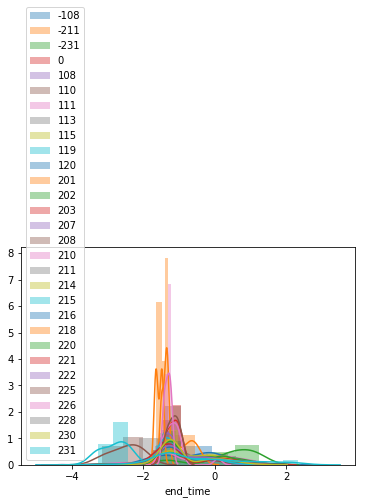

In [28]:
for indv in np.unique(syllable_df.indv):
    sns.distplot(np.log(syllable_df[syllable_df.indv==indv]["end_time"]), label=indv)
plt.legend()

In [29]:
with Parallel(n_jobs=n_jobs, verbose=verbosity) as parallel:

    syllables_spec = parallel(
        delayed(pad_spectrogram)(spec, pad_length)
        for spec in tqdm(
            syllables_spec, desc="padding spectrograms", leave=False
        )
    )

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 1920 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 21420 tasks      | elapsed:    2.9s


[Parallel(n_jobs=-1)]: Done 31646 out of 31646 | elapsed:    3.9s finished


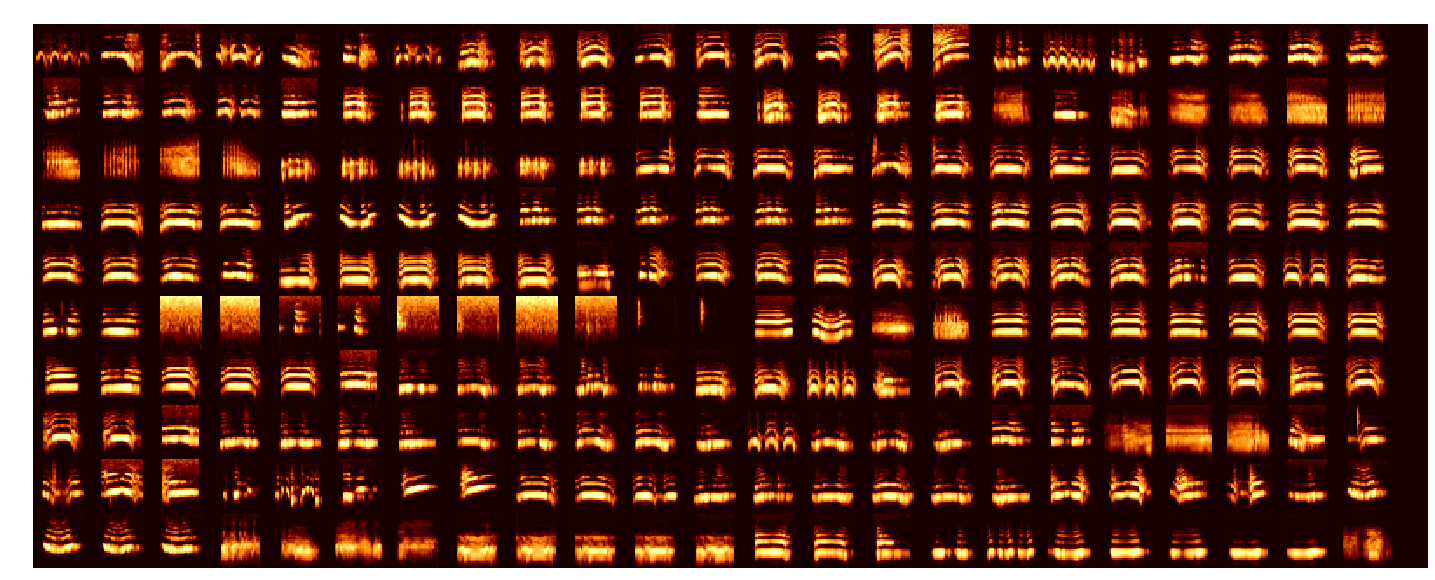

In [30]:
draw_spec_set(syllables_spec, zoom=1, maxrows=10, colsize=25)

In [31]:
syllable_df['spectrogram'] = syllables_spec

In [32]:
syllable_df[:3]

start_time  end_time indv  indvi                 key  \
0      0.2140    0.3065    0      0  121220031934346505   
1      0.3165    0.3360    0      0  121220031934346505   
2      0.3375    0.3590    0      0  121220031934346505   

                                               audio    rate  \
0  [-0.01634356, -0.016108407, -0.01484951, -0.01...  250000   
1  [-0.04675521, -0.054559425, -0.07107724, -0.05...  250000   
2  [0.04236861, 0.014425384, -0.026170516, -0.043...  250000   

                                         spectrogram  
0  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
1  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...  
2  [[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...

In [33]:
# remove noise spectrograms
syll_shape = np.shape(syllables_spec[0])
bad_specs = np.array([np.argmax(np.sum(i, axis=1)) > ((syll_shape[0]*.9)-1) for i in syllables_spec])
print(np.sum(bad_specs))

2071


In [34]:
syllable_df = syllable_df[bad_specs==False]

In [35]:
len(syllable_df)

29575

### view syllables per indv

In [36]:
syllable_df.indv.unique()

array(['0', '230', '207', '221', '220', '211', '231', '108', '111', '120',
       '216', '222', '115', '203', '215', '202', '214', '113', '-211',
       '208', '-231', '210', '228', '201', '225', '218', '-108', '226'],
      dtype=object)

0 18839


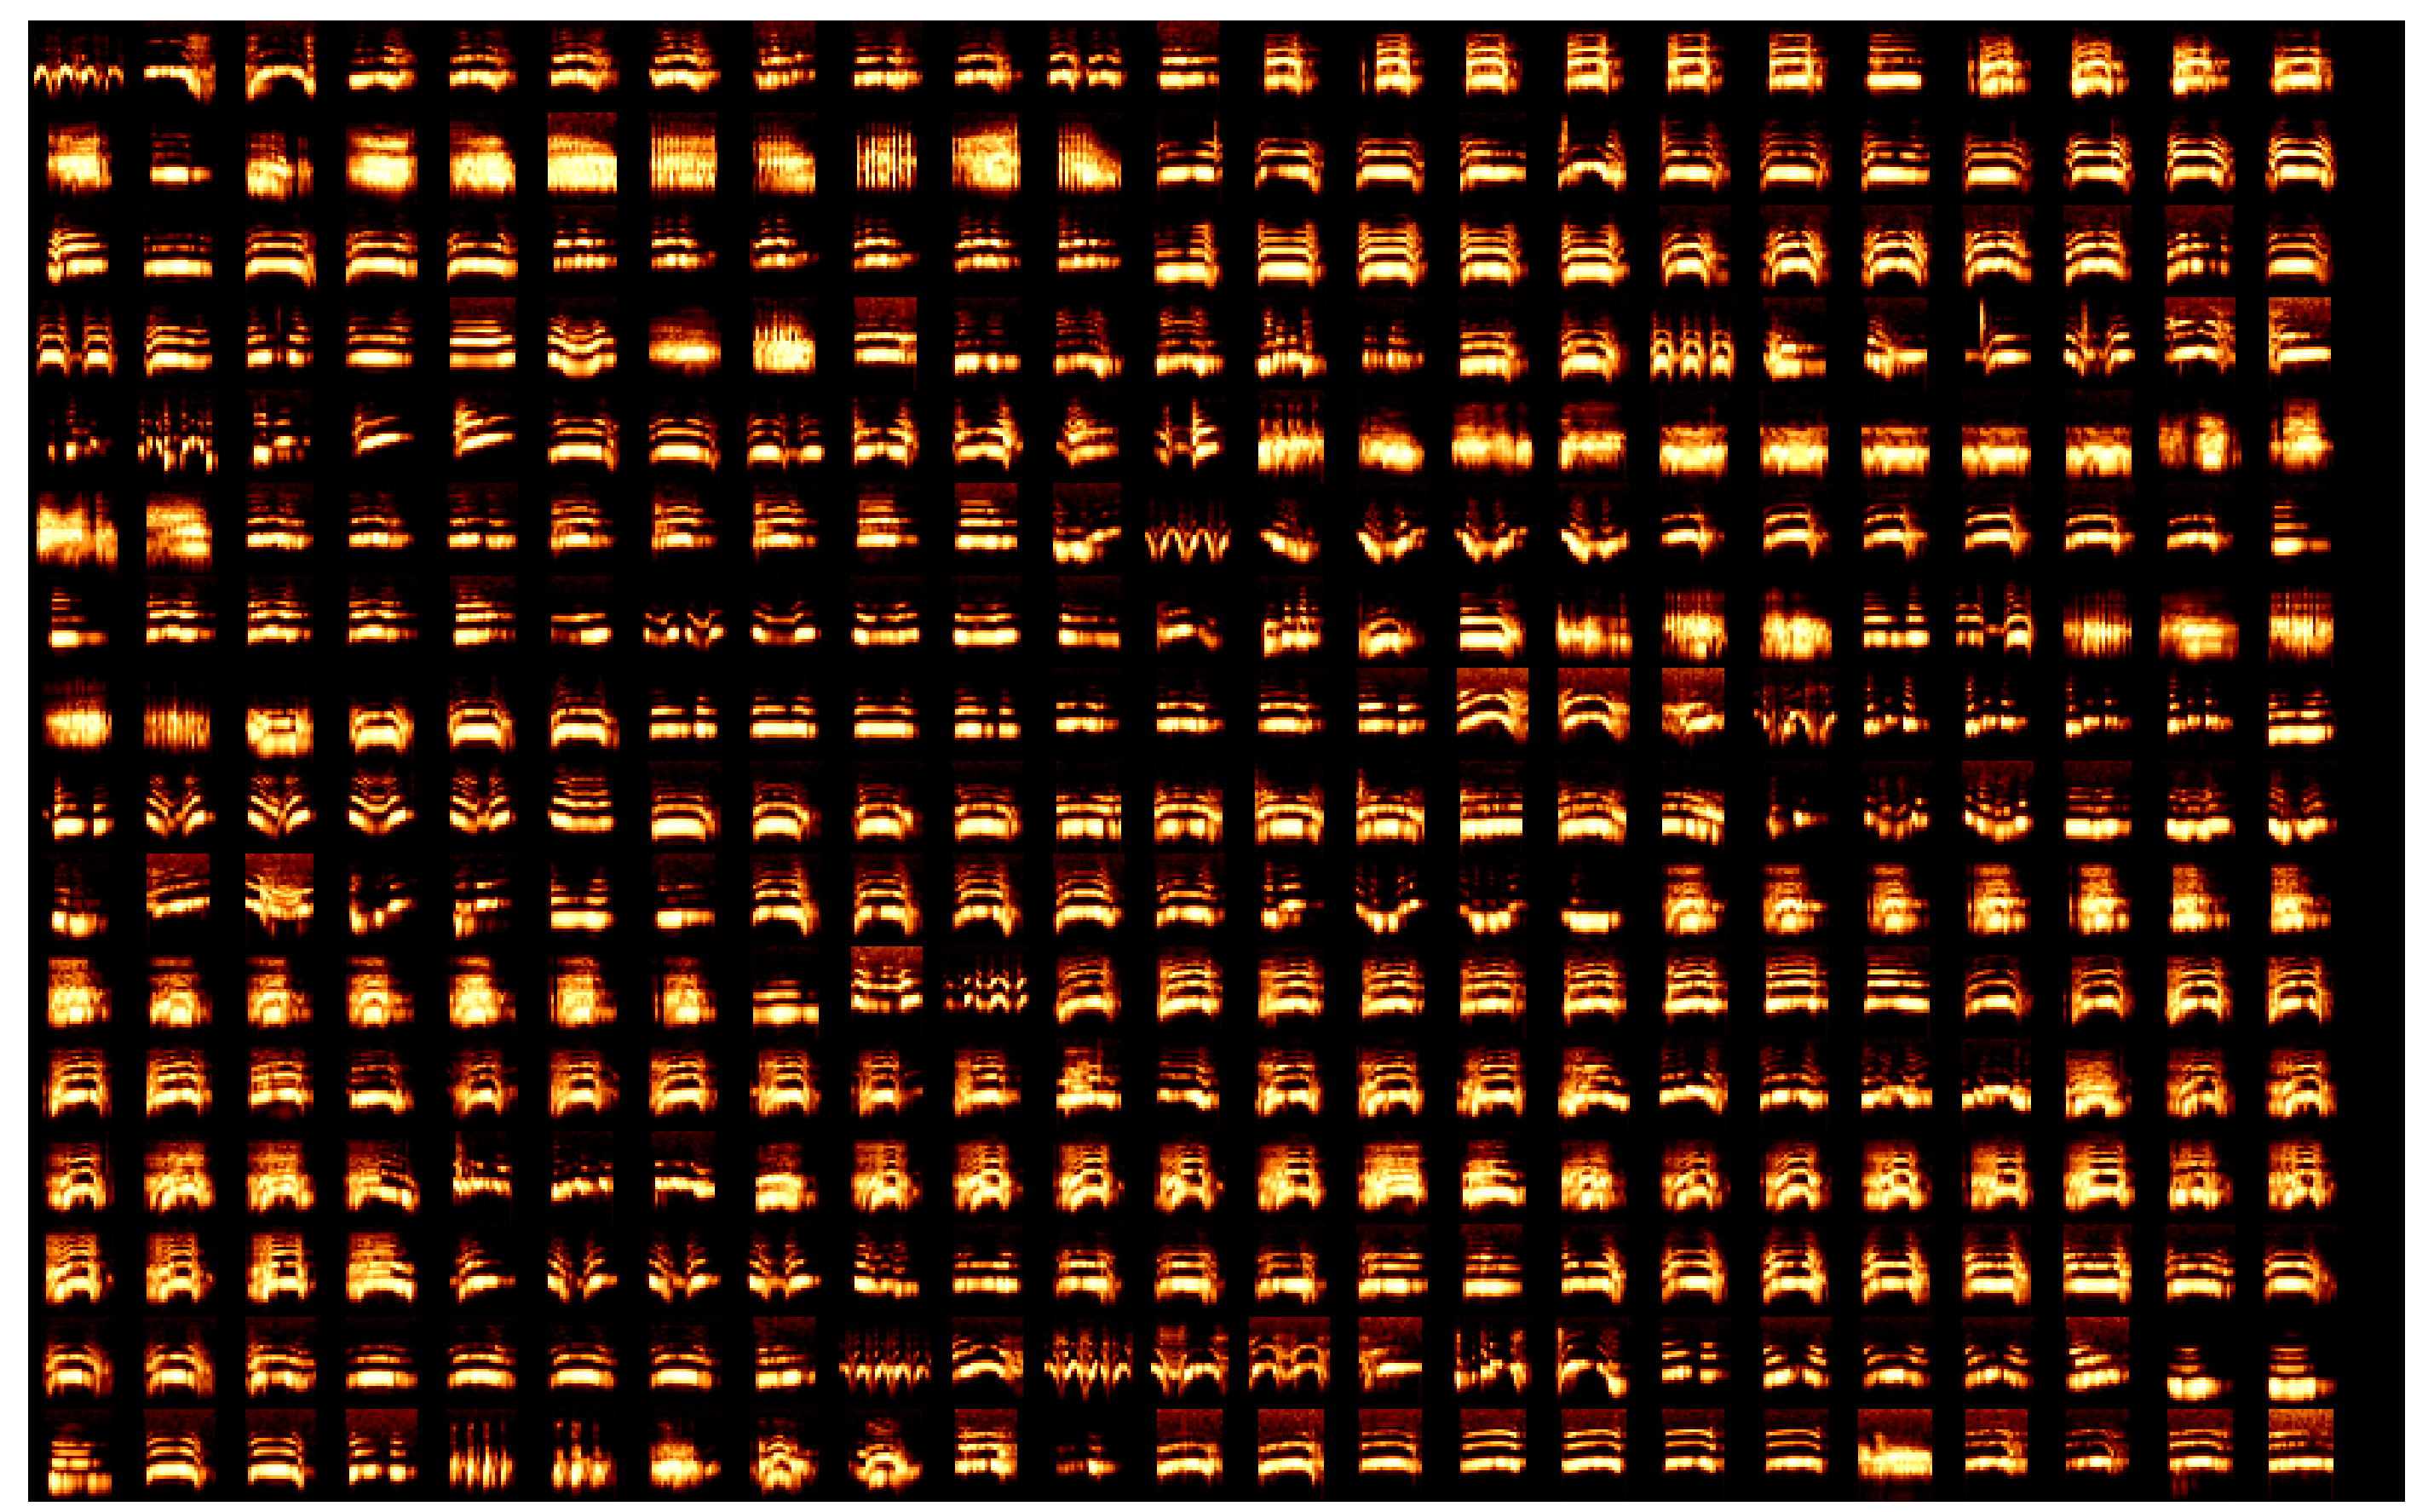

207 579


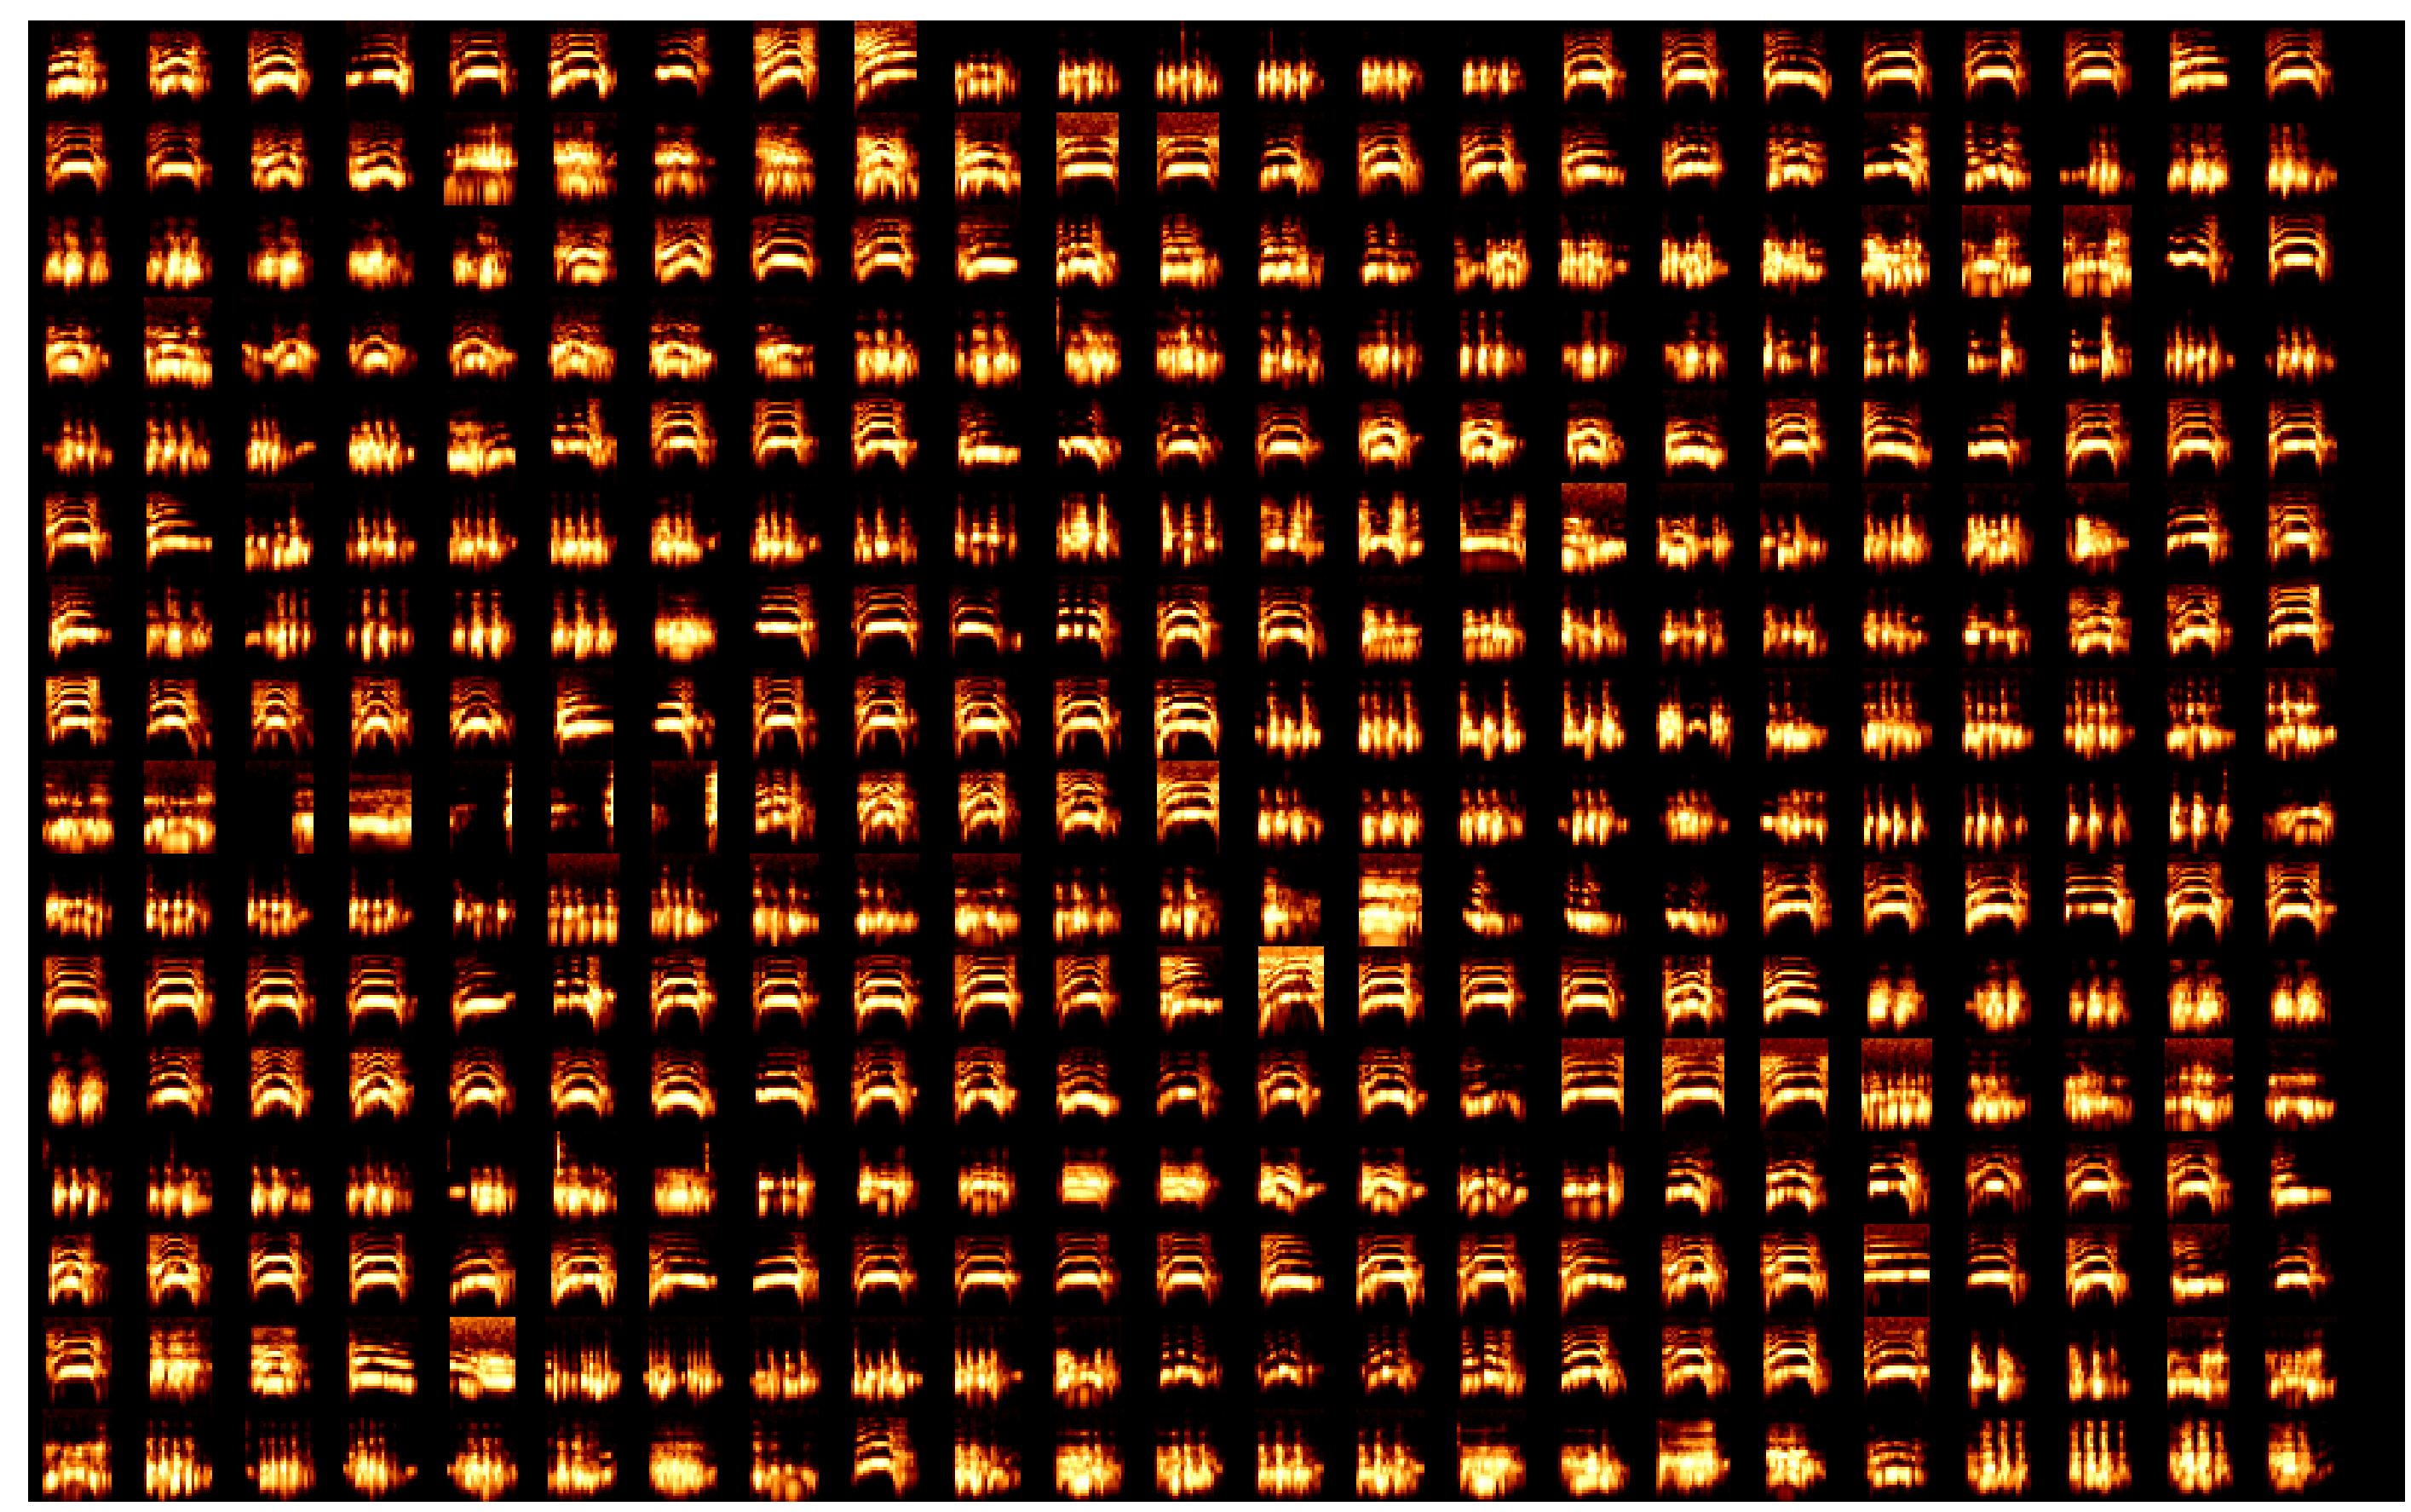

221 602


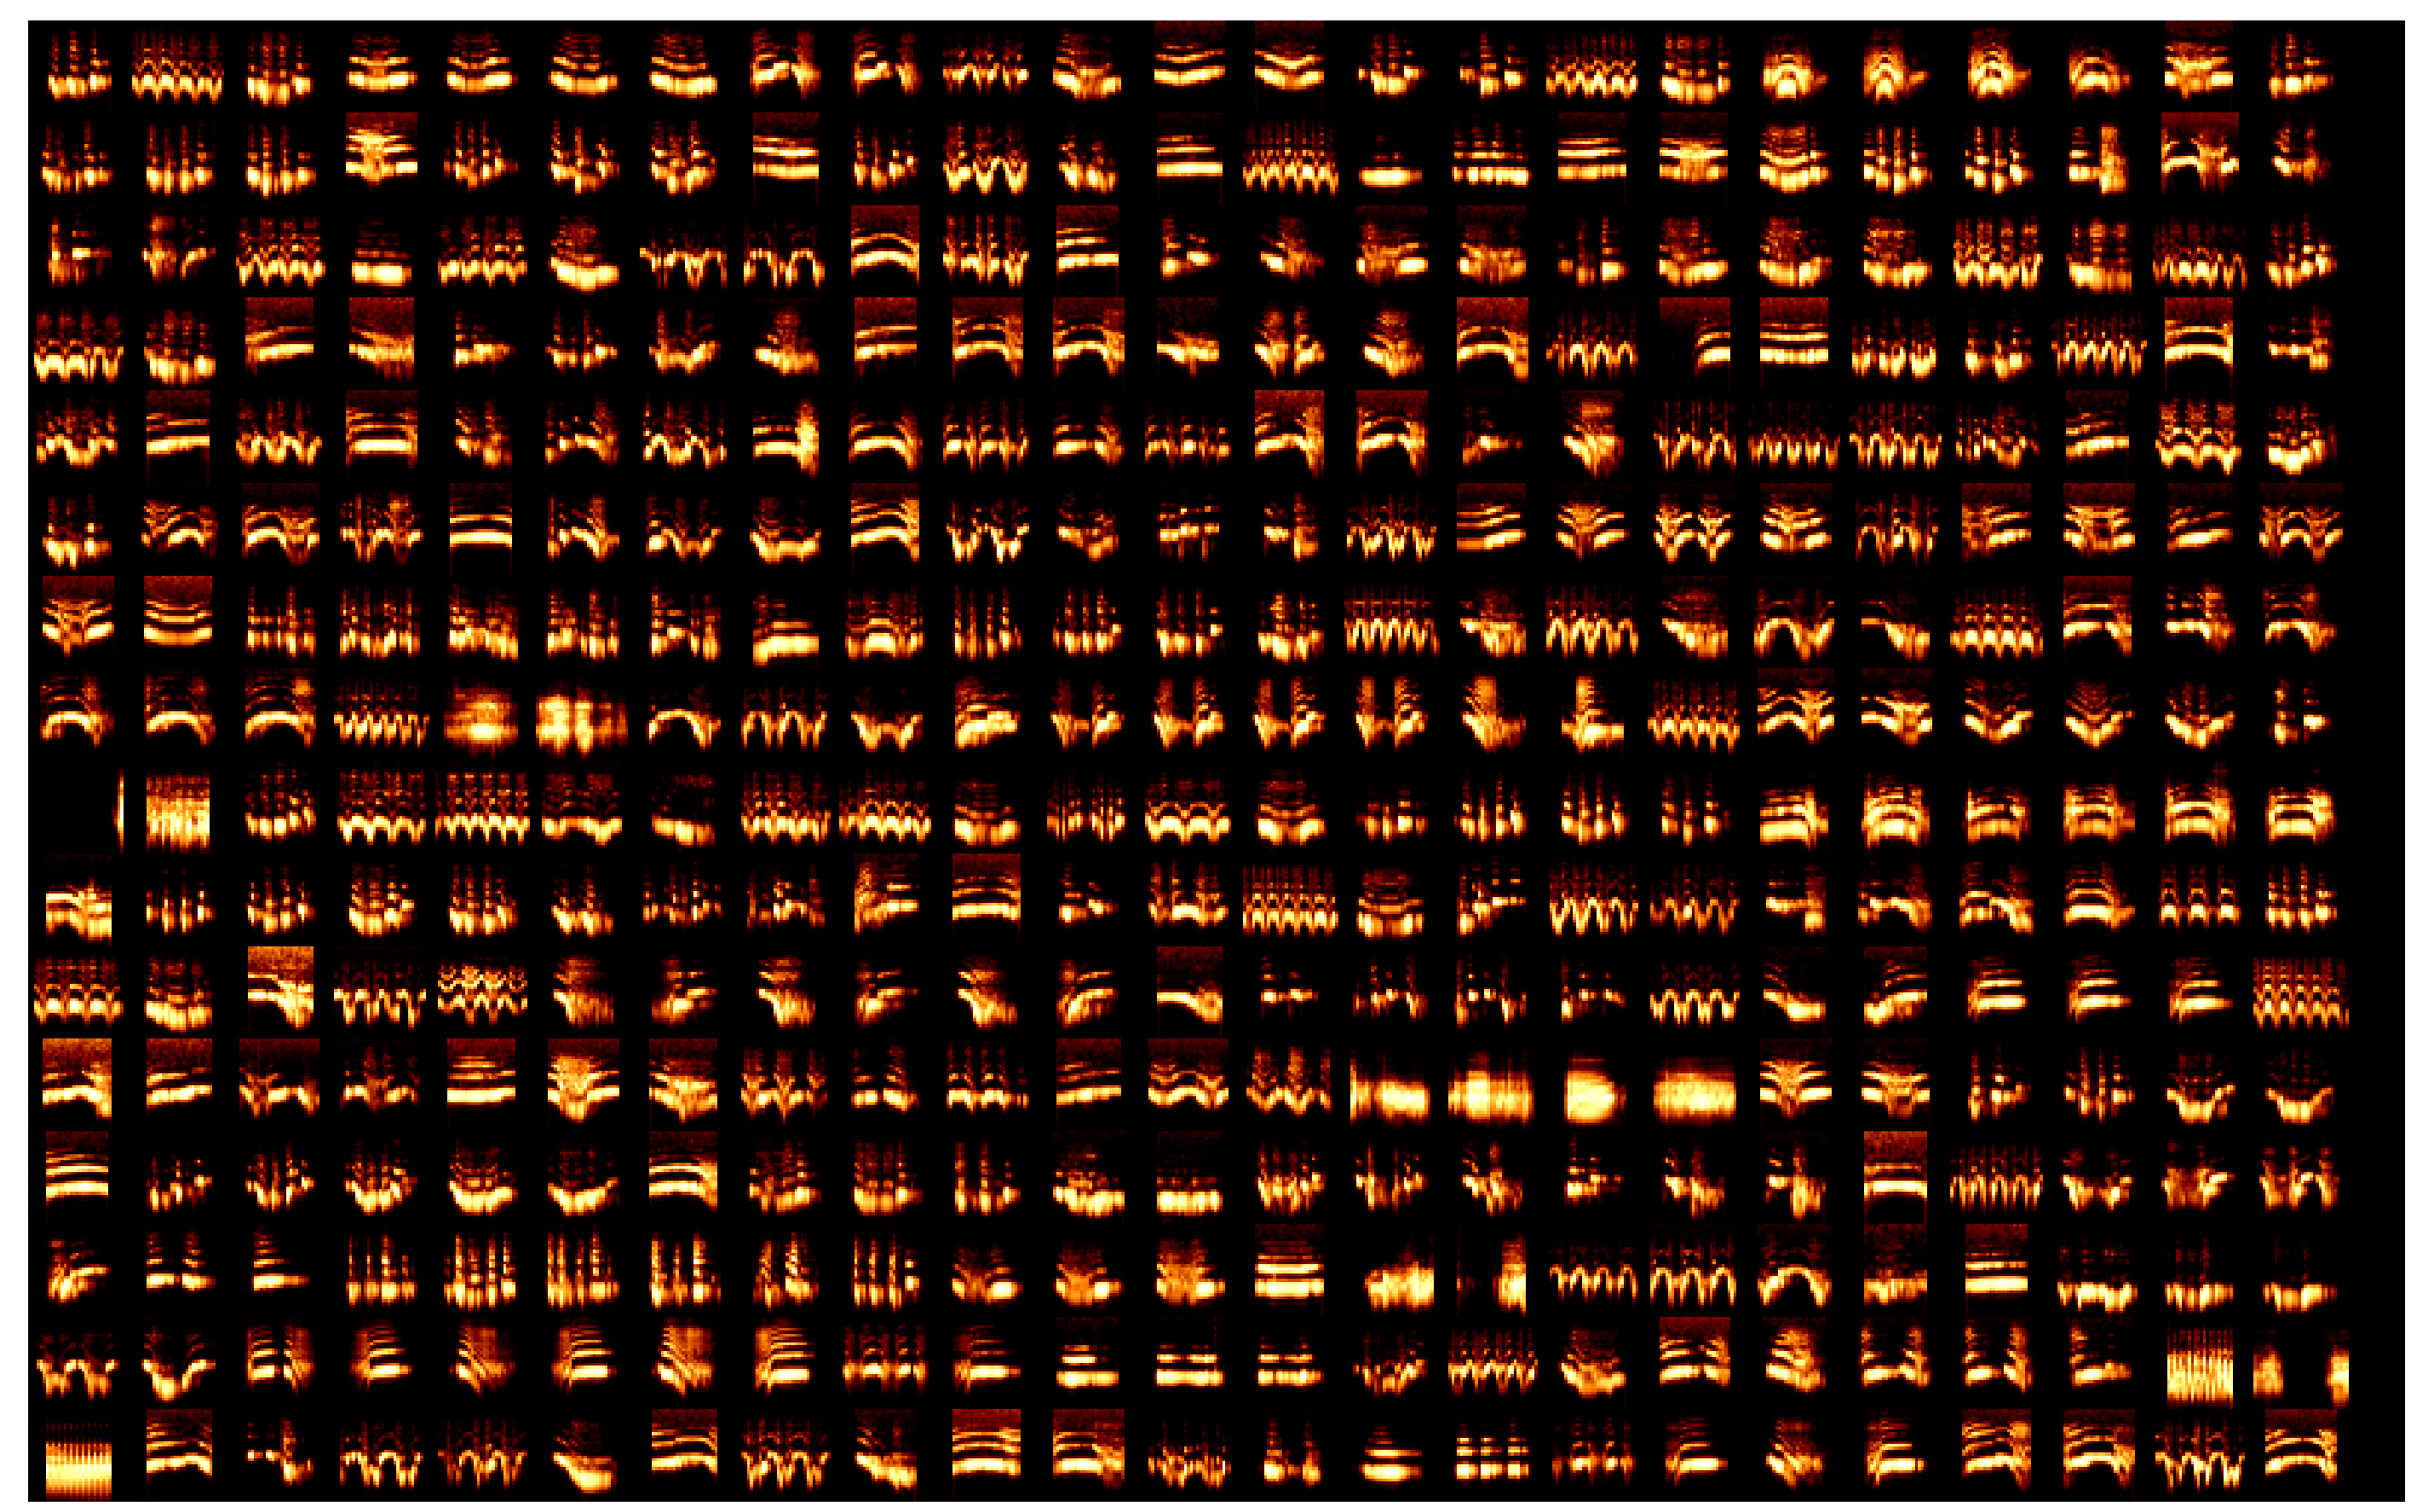

230 596


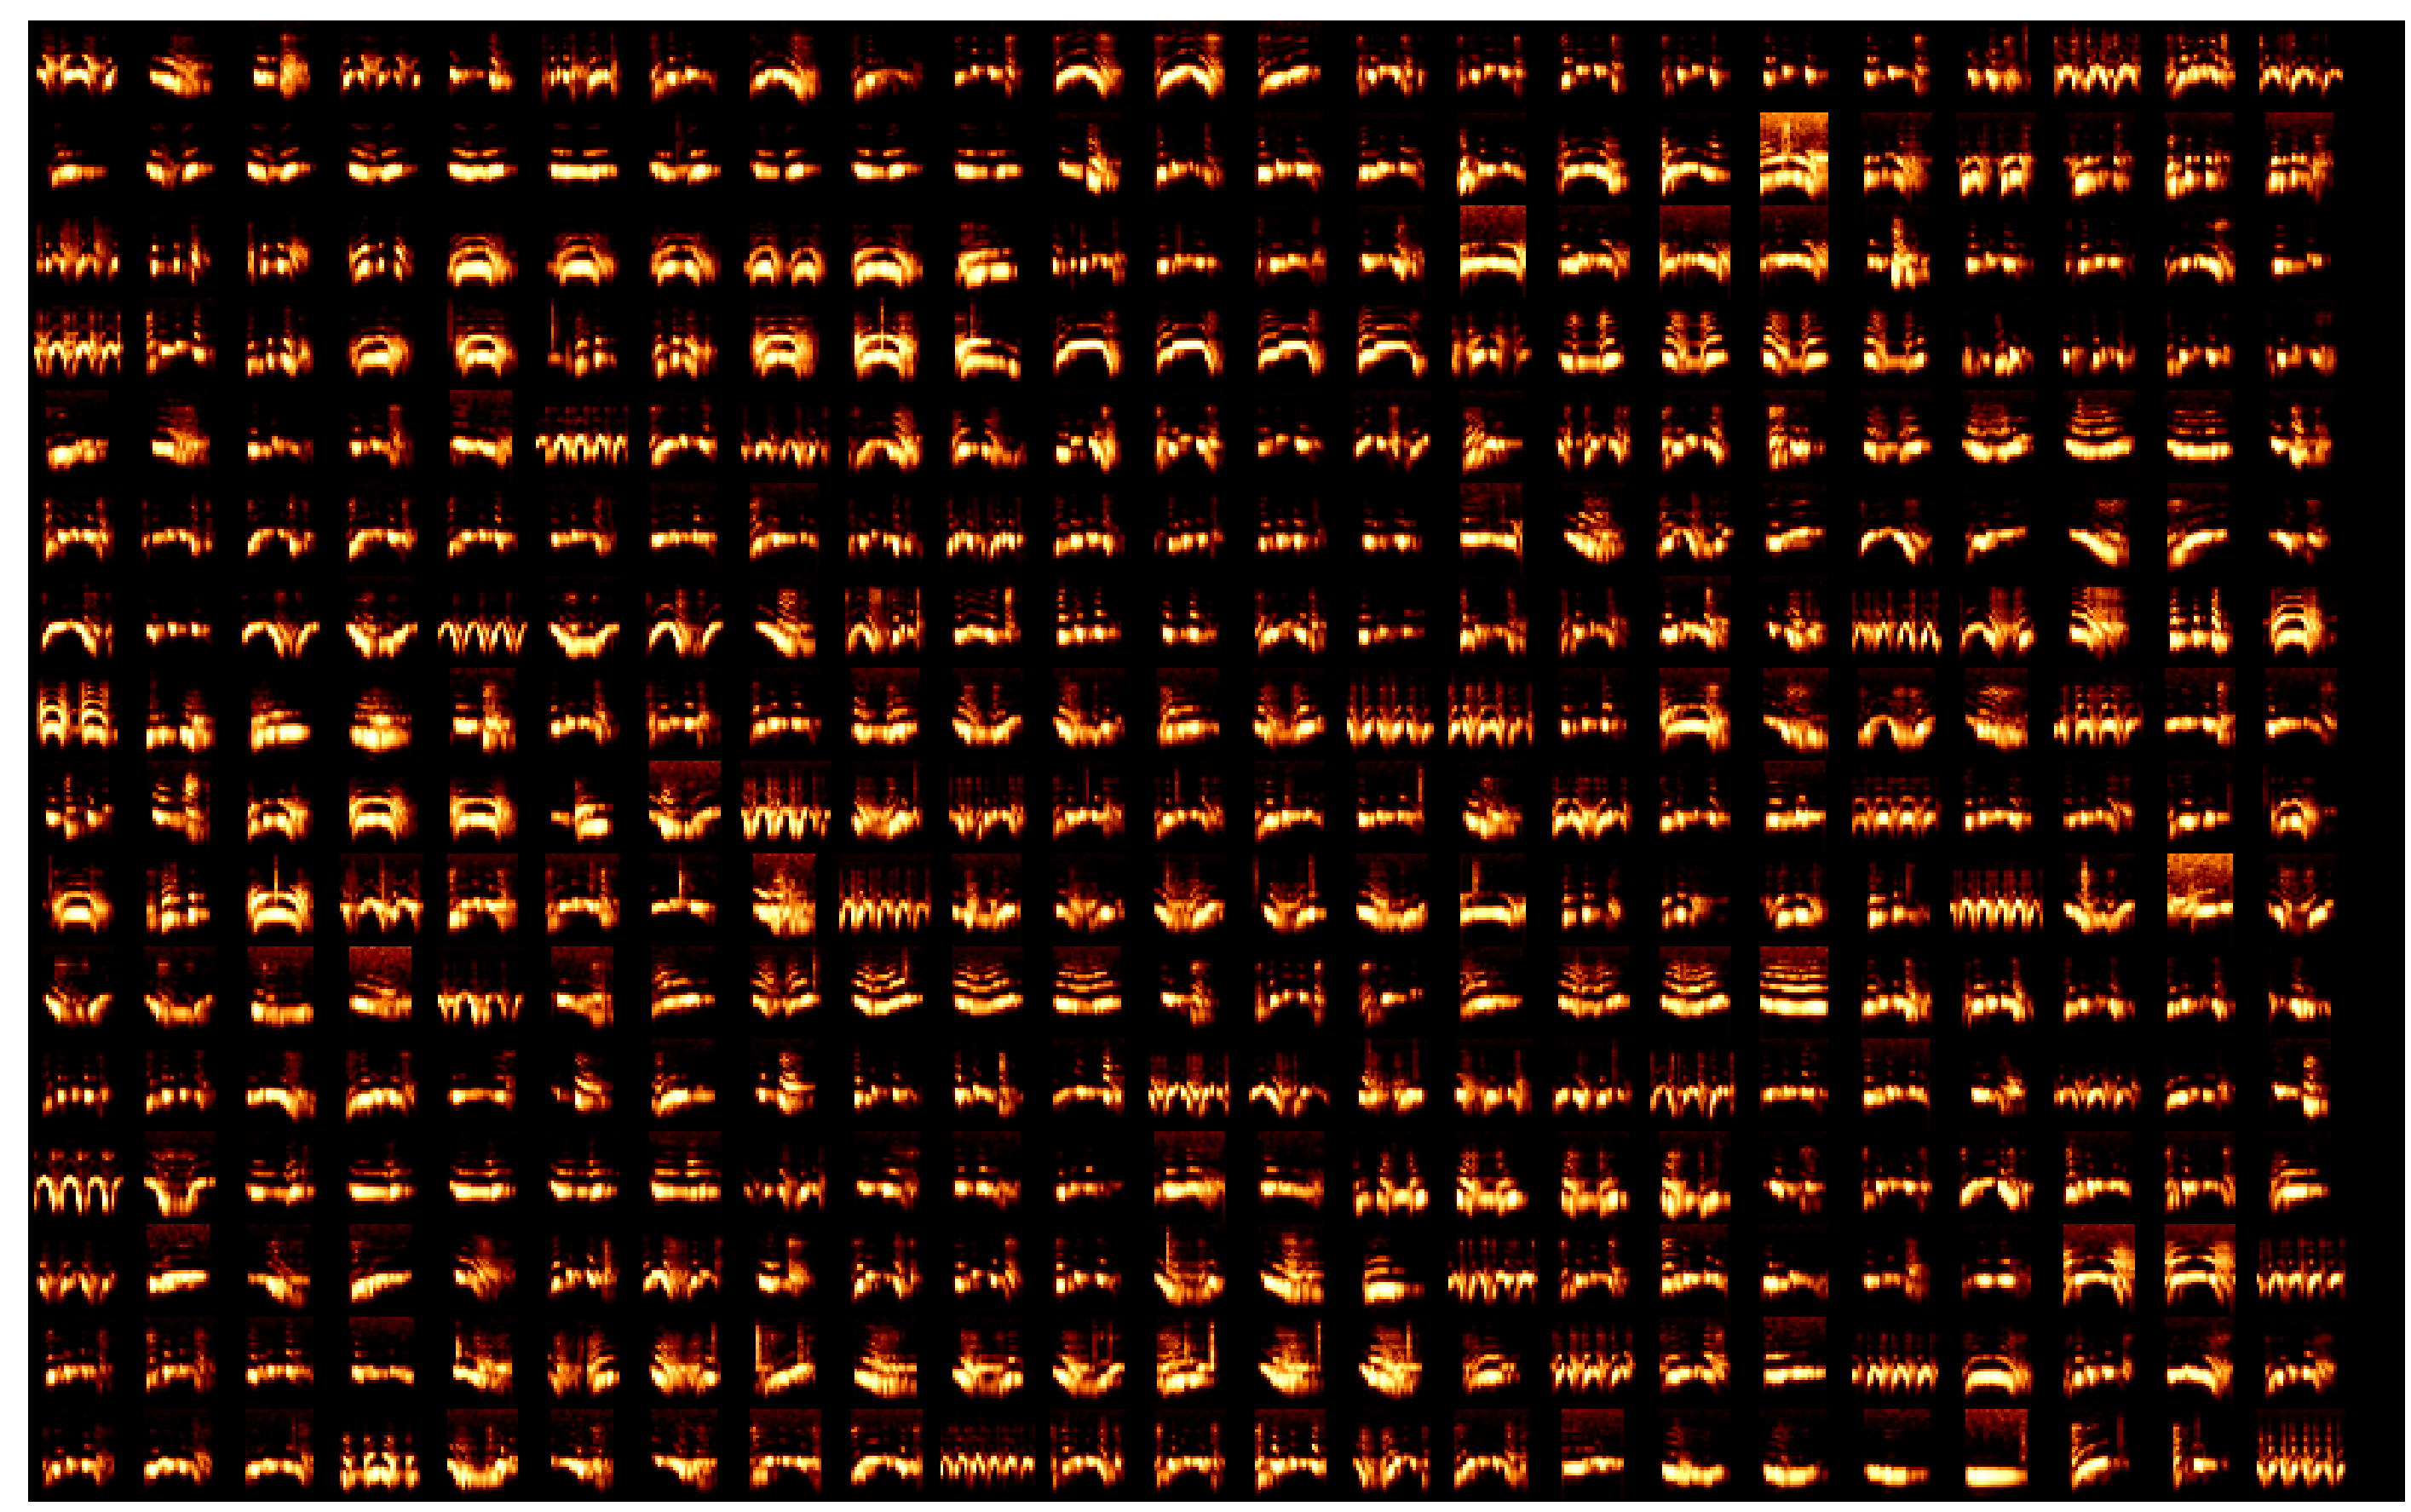

In [37]:
for indv in np.sort(syllable_df.indv.unique()[:4]):
    print(indv, np.sum(syllable_df.indv == indv))
    specs = np.array([i/np.max(i) for i in syllable_df[syllable_df.indv == indv].spectrogram.values])
    specs[specs<0] = 0
    draw_spec_set(specs, zoom=2,
                  maxrows=16, 
                  colsize=25)

### save dataset

In [38]:
save_loc = DATA_DIR / 'syllable_dfs' / DATASET_ID / 'isolation_r3.pickle'
ensure_dir(save_loc)
syllable_df.to_pickle(save_loc)